In [ ]:
!pip install torchtext==0.10.0
!pip install --upgrade xlrd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

torch.manual_seed(1)

train_path = '../data/Constraint_English_Train.xls'
val_path = '../data/Constraint_English_Val.xls'
test_path = '../data/english_test_with_labels.xls'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
preprocssed_prefix = 'preprocessed/'

def text_preprocessing(text_path):
  df = pd.read_excel(text_path, header=0)
  df = df.drop(columns=['id'])
  df['label'] = (df['label'] == 'fake').astype('int')
  df.to_csv(preprocssed_prefix + text_path.split('.')[0] + '.csv', index=False)
  return df

In [ ]:
df_train = text_preprocessing(train_path)
df_test = text_preprocessing(test_path)
df_val = text_preprocessing(val_path)

In [ ]:
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('tweet', text_field), ('label', label_field)]

test = TabularDataset(path='./' + preprocssed_prefix + test_path.split('.')[0] + '.csv',
                      format='csv',
                      skip_header=True, 
                      fields=fields)

train = TabularDataset(path='./' + preprocssed_prefix + train_path.split('.')[0] + '.csv',
                      format='csv',
                      skip_header=True, 
                      fields=fields)

valid = TabularDataset(path='./' + preprocssed_prefix + val_path.split('.')[0] + '.csv',
                      format='csv',
                      skip_header=True, 
                      fields=fields)

# Iterators
train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.tweet), device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.tweet), device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.tweet), device=device, sort=True, sort_within_batch=True)

text_field.build_vocab(train)


/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


{'tweet': ['politically', 'correct', 'woman', '(', 'almost', ')', 'uses', 'pandemic', 'as', 'excuse', 'not', 'to', 'reuse', 'plastic', 'bag', 'https://t.co/thf8gunfpe', '#', 'coronavirus', '#', 'nashville'], 'label': '1'}


In [ ]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 150)
        self.lstm = nn.LSTM(150,
                              dimension,
                              num_layers = 2,
                              bidirectional = True,
                              dropout = 0.3,
                              batch_first = True
                            )
          
        # Dense layer to predict 
        self.fc = nn.Linear(dimension * 2, 1)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_len):

        embedded = self.embedding(text)
        
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len.cpu(),batch_first=True)
        
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)
        
        return outputs

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    criterion = criterion.to(device)
    for epoch in range(num_epochs):
        for batch in train_loader:
            tweet, tweet_len = batch.tweet           
            labels = batch.label.to(device)
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)
            output = model(tweet, tweet_len).squeeze()

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            acc = binary_accuracy(output, labels)

            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for batch in train_loader:
                      tweet, tweet_len = batch.tweet           
                      labels = batch.label.to(device)
                      tweet = tweet.to(device)
                      tweet_len = tweet_len.to(device)
                      output = model(tweet, tweet_len).squeeze()

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                      valid_acc = binary_accuracy(output, labels)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                print(f'\tTrain Acc: {acc*100:.2f}% | Val. Acc: {valid_acc*100:.2f}%')
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model=model, optimizer=optimizer, num_epochs=15)

Epoch [1/15], Step [50/1515], Train Loss: 0.6773, Valid Loss: 2.0331
	Train Acc: 35.94% | Val. Acc: 90.00%
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/15], Step [100/1515], Train Loss: 0.5746, Valid Loss: 1.8700
	Train Acc: 46.88% | Val. Acc: 85.00%
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/15], Step [150/1515], Train Loss: 0.4694, Valid Loss: 1.6477
	Train Acc: 68.75% | Val. Acc: 95.00%
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/15], Step [200/1515], Train Loss: 0.3786, Valid Loss: 1.4530
	Train Acc: 73.44% | Val. Acc: 95.00%
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [5/15], Step [250/1515], Train Loss: 0.3090, Valid Loss: 1.2789
	Train Acc: 75.00% | Val. Acc: 100.00%
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [6/15], Step [300/1515], Train Loss: 0.2466, Valid Loss: 1.1256
	Train Acc: 78.12% | Val. Acc: 95.00%
Model saved to ==> .//model.pt
M

Model loaded from <== ./metrics.pt


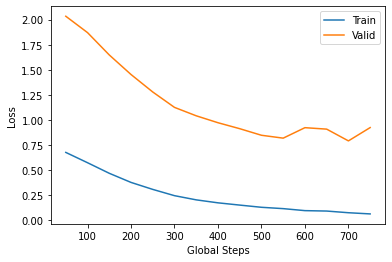

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('./metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./model.pt
tensor([0.9999, 0.0321, 0.9999, 0.7300, 0.9994, 0.9183, 0.9998, 0.9997, 0.9999,
        0.9999, 0.9999, 0.9994, 0.9998, 0.9996, 0.4228, 0.9996, 0.9694, 0.9996,
        0.0213, 0.9995, 0.9999, 0.9995, 0.9371, 0.2989, 0.9956, 0.9996, 0.9235,
        0.5077, 0.8544, 0.9805, 0.9999, 0.9998, 0.9998, 0.0446, 0.5279, 0.9998,
        0.9999, 0.9825, 0.9917, 0.9999, 0.9804, 0.9996, 0.7140, 0.0277, 0.9974,
        0.9997, 0.9482, 0.9938, 0.9999, 0.9994, 0.7285, 0.9991, 0.9984, 0.9997,
        0.9972, 0.9979, 0.9930, 0.9994, 0.9951, 0.9861, 0.9868, 0.9975, 0.9998,
        0.9298], device='cuda:0')
tensor([0.9855, 0.9999, 0.9135, 0.9786, 0.9999, 0.0085, 0.9996, 0.0095, 0.9967,
        0.9999, 0.0609, 0.0466, 0.5947, 0.9997, 0.9982, 0.0471, 0.9985, 0.9814,
        0.4310, 0.9999, 0.4010, 0.9993, 0.8716, 0.9996, 0.9998, 0.9997, 0.9999,
        0.9972, 0.9993, 0.9997, 0.0314, 0.9709, 0.9999, 0.0251, 0.9988, 0.9994,
        0.9999, 0.9995, 0.9975, 0.9999, 0.9957, 0.999

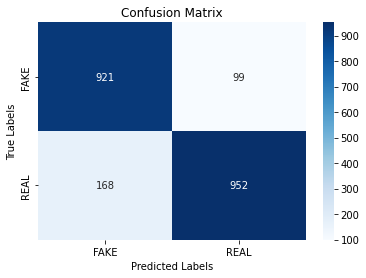

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            tweet, tweet_len = batch.tweet           
            labels = batch.label.to(device)
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)
            output = model(tweet, tweet_len).squeeze()

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print('Accuracy: ', cm.diagonal().sum() /(cm.sum(axis = 1).sum()))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
        
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('model.pt', best_model, optimizer)
evaluate(best_model, test_iter)